In [3]:
import gym
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})


In [2]:
from tictac import TicTacToe, plot_test_game
from tqdm import tqdm

In [29]:
def sample_action(Q, state, empty_spaces, eps):
    number_of_moves = len(empty_spaces)
    idx_action = np.random.randint(number_of_moves)
    if state in Q:  
        if random.random() > eps:
            idx_action = np.argmax(Q[state])
    else:
        Q[state] = np.zeros(number_of_moves)
    return idx_action, empty_spaces[idx_action]



In [30]:
def Q_learning(env, pi_crosses, pi_noughts, alpha, epsilon, gamma):
    env.reset()
    s, empty_spaces, turn = env.getState()
    terminated = False
    crosses_state,  crosses_action = None, None
    noughts_state, noughts_action = None, None
    while not terminated:
        if turn == 1:  # крестики
            idx_action, aсtion = sample_action(pi_crosses, s, empty_spaces, eps=epsilon)
            state_new, reward, terminated, _ = env.step(aсtion)
            if reward == 1:
                pi_crosses[s][idx_action] = 1
            if noughts_state: 
                pi_noughts[noughts_state][noughts_action] += alpha * \
                (- 1 * reward + gamma * np.max(pi_noughts.get(state_new[0], 0)) \
                 -  pi_noughts[noughts_state][noughts_action])
            crosses_state, crosses_action = s, idx_action
            
        elif turn == -1:  # нолики
            idx_action, aсtion = sample_action(pi_noughts, s, empty_spaces, eps=epsilon)  
            state_new, reward, terminated, _ = env.step(aсtion)
            if reward == -1:
                pi_noughts[s][idx_action] = 1
            if crosses_state:
                pi_crosses[crosses_state][crosses_action] += alpha * \
                (reward + gamma * np.max(pi_crosses.get(state_new[0], 0)) \
                 - pi_crosses[crosses_state][crosses_action])
            noughts_state, noughts_action = s, idx_action
            
        s, empty_spaces, turn = state_new

In [31]:
def play_game(env, pi_crosses, pi_noughts, game_type):
    env.reset()
    s, empty_spaces, turn = env.getState()
    done = False
    while not done:
        Q = pi_crosses if game_type == 1 else pi_noughts
        eps = 0 if game_type == turn else 1
        idx_aсtion, aсtion = sample_action(Q, s, empty_spaces, eps=eps)
        state, reward, done, _ = env.step(aсtion)
        s, empty_spaces, turn = state
    return reward

In [32]:
def plot_stats(indicies, wins, title):
    plt.plot(indicies, wins)
    plt.xlabel("Количество эпизодов")
    plt.ylabel("Доля побед")
    plt.title(title)
    plt.grid(True)
    plt.show()


In [33]:
def learning(env, env_name, alpha, epsilon, gamma, q_learning_episodes_count,
             run_experiment_every, experiment_games_count):
    
    pi_crosses, pi_noughts = dict(), dict()
    indicies = []
    noughts_stat, crosses_stat = [], []

    for i in tqdm(range(q_learning_episodes_count)):
        Q_learning(env, pi_crosses, pi_noughts, alpha=0.015, epsilon=0.3, gamma=1.0)
        if i % run_experiment_every == 0: 
            current_noughts_stat, current_crosses_stat = [], []
            for _ in range(experiment_games_count):
                current_noughts_stat.append(play_game(env, pi_crosses, pi_noughts, game_type=-1))
                current_crosses_stat.append(play_game(env, pi_crosses, pi_noughts, game_type=1))
            noughts_stat.append(current_noughts_stat.count(-1) / experiment_games_count)
            crosses_stat.append(current_crosses_stat.count(1) / experiment_games_count)           
            indicies.append(i)

    plot_stats(indicies, crosses_stat, f"Крестики против случайной стратегии {env_name}")
    plot_stats(indicies, noughts_stat, f"Нолики против случайной стратегии  {env_name}")


In [34]:


alpha = 0.02
epsilon = 0.3
gamma = 0.9
experiment_games_count = 1_000
run_experiment_every = 5_000
q_learning_episodes_count = 200_000



# Часть первая: крестики-нолики при помощи Q-обучения


100%|█████████████████████████████████| 200000/200000 [01:13<00:00, 2709.06it/s]


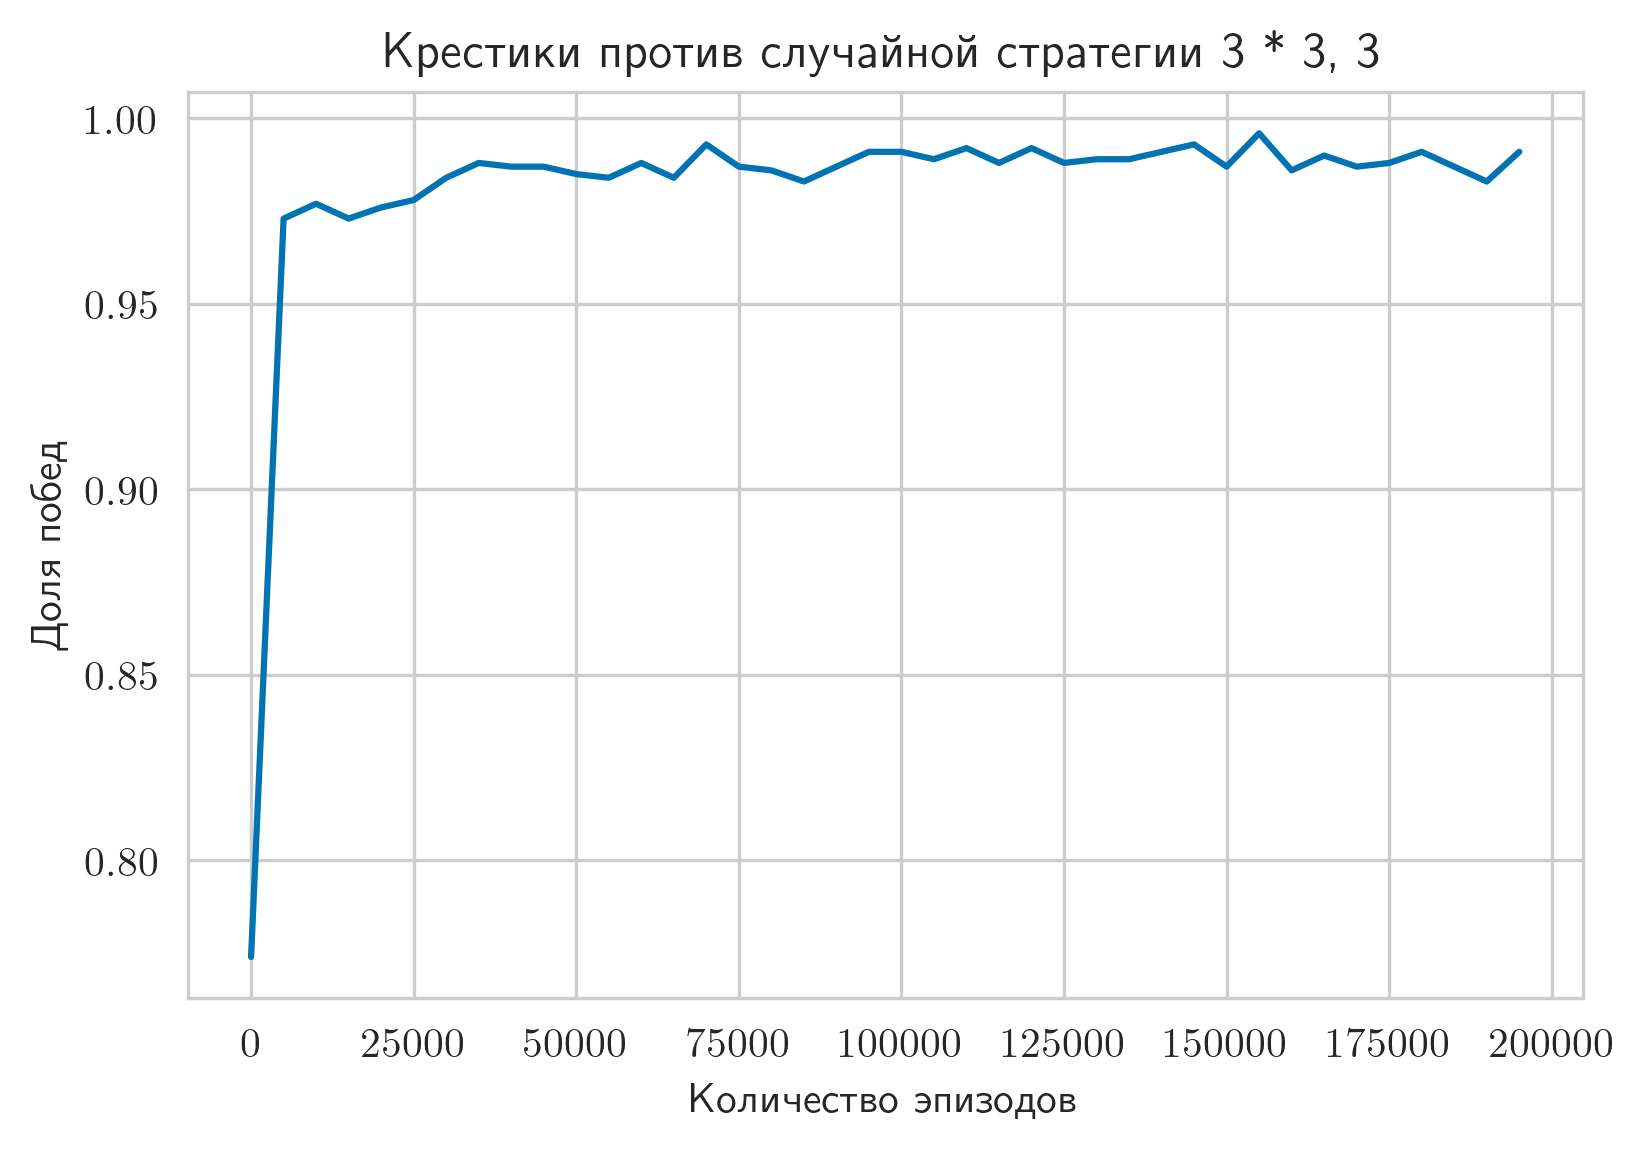

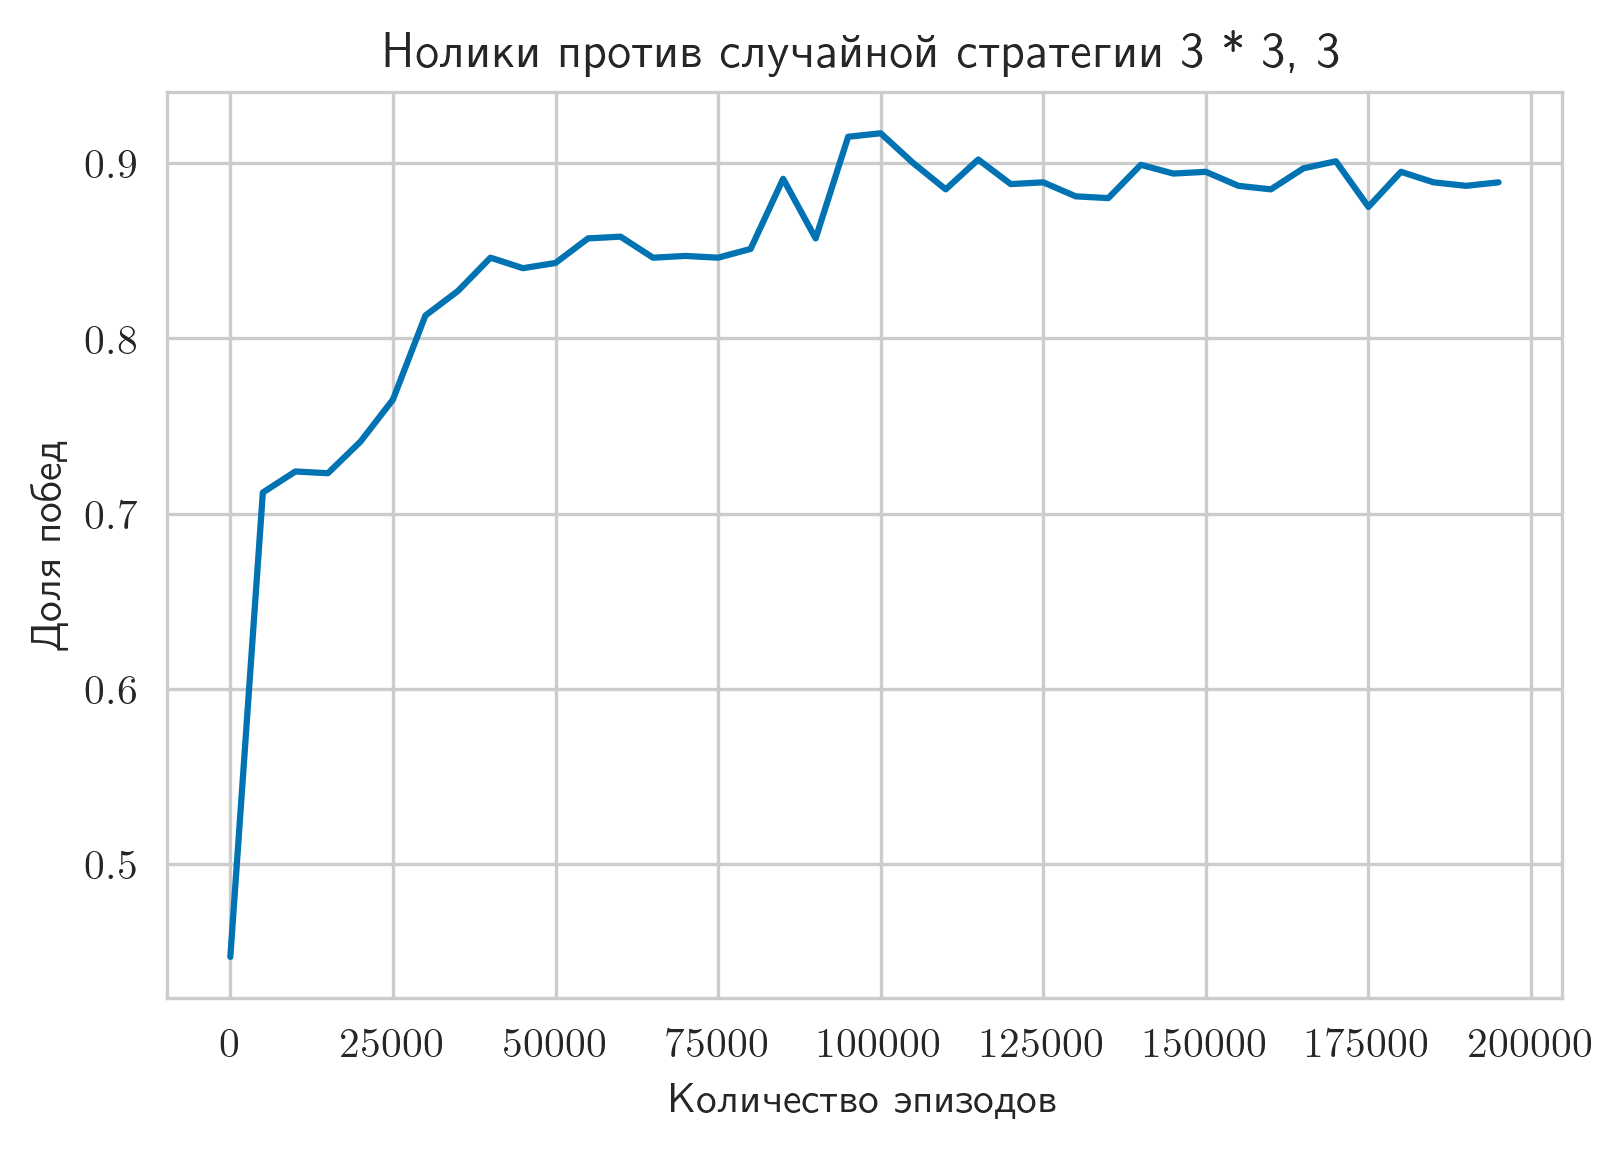

In [35]:
env = TicTacToe(3, 3, 3)
env_name = "3 * 3, 3"
learning(env, env_name, alpha, epsilon, gamma, q_learning_episodes_count, run_experiment_every, experiment_games_count)

In [36]:


alpha = 0.015
epsilon = 0.3
gamma = 1
experiment_games_count = 1_000
run_experiment_every = 5_000
q_learning_episodes_count = 300_000



100%|█████████████████████████████████| 300000/300000 [04:20<00:00, 1152.86it/s]


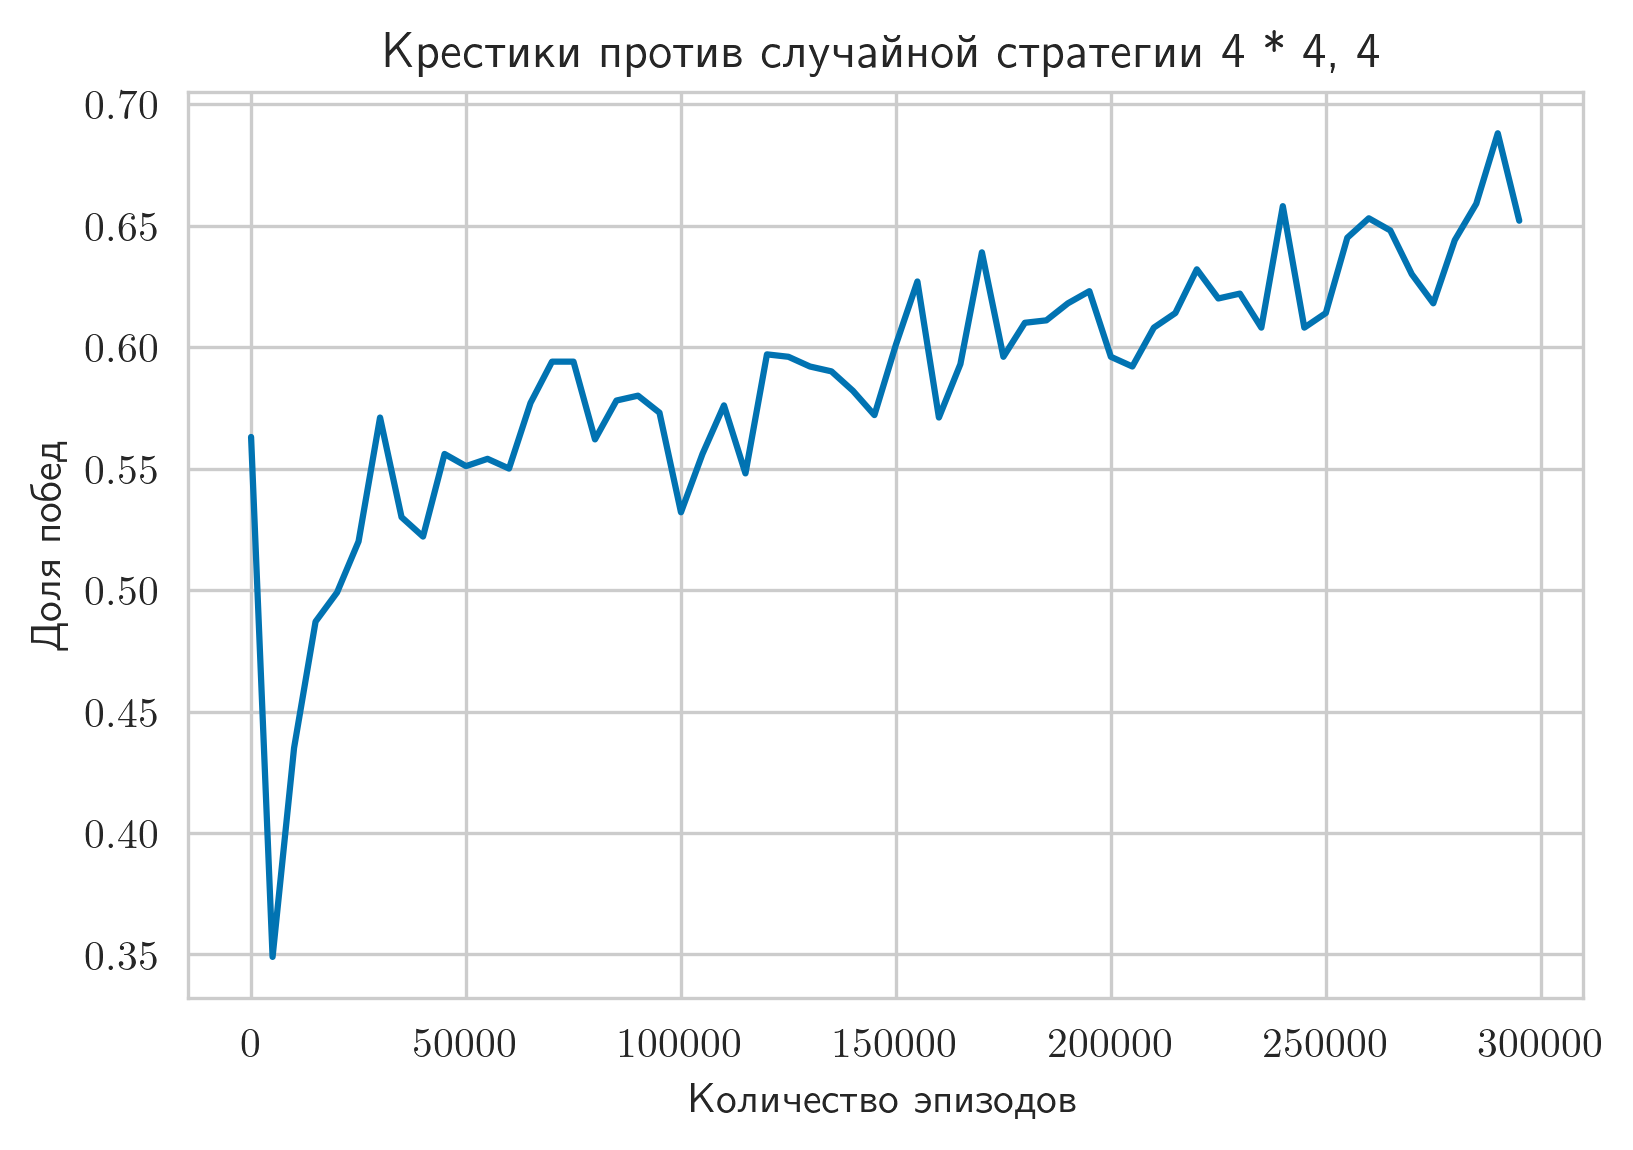

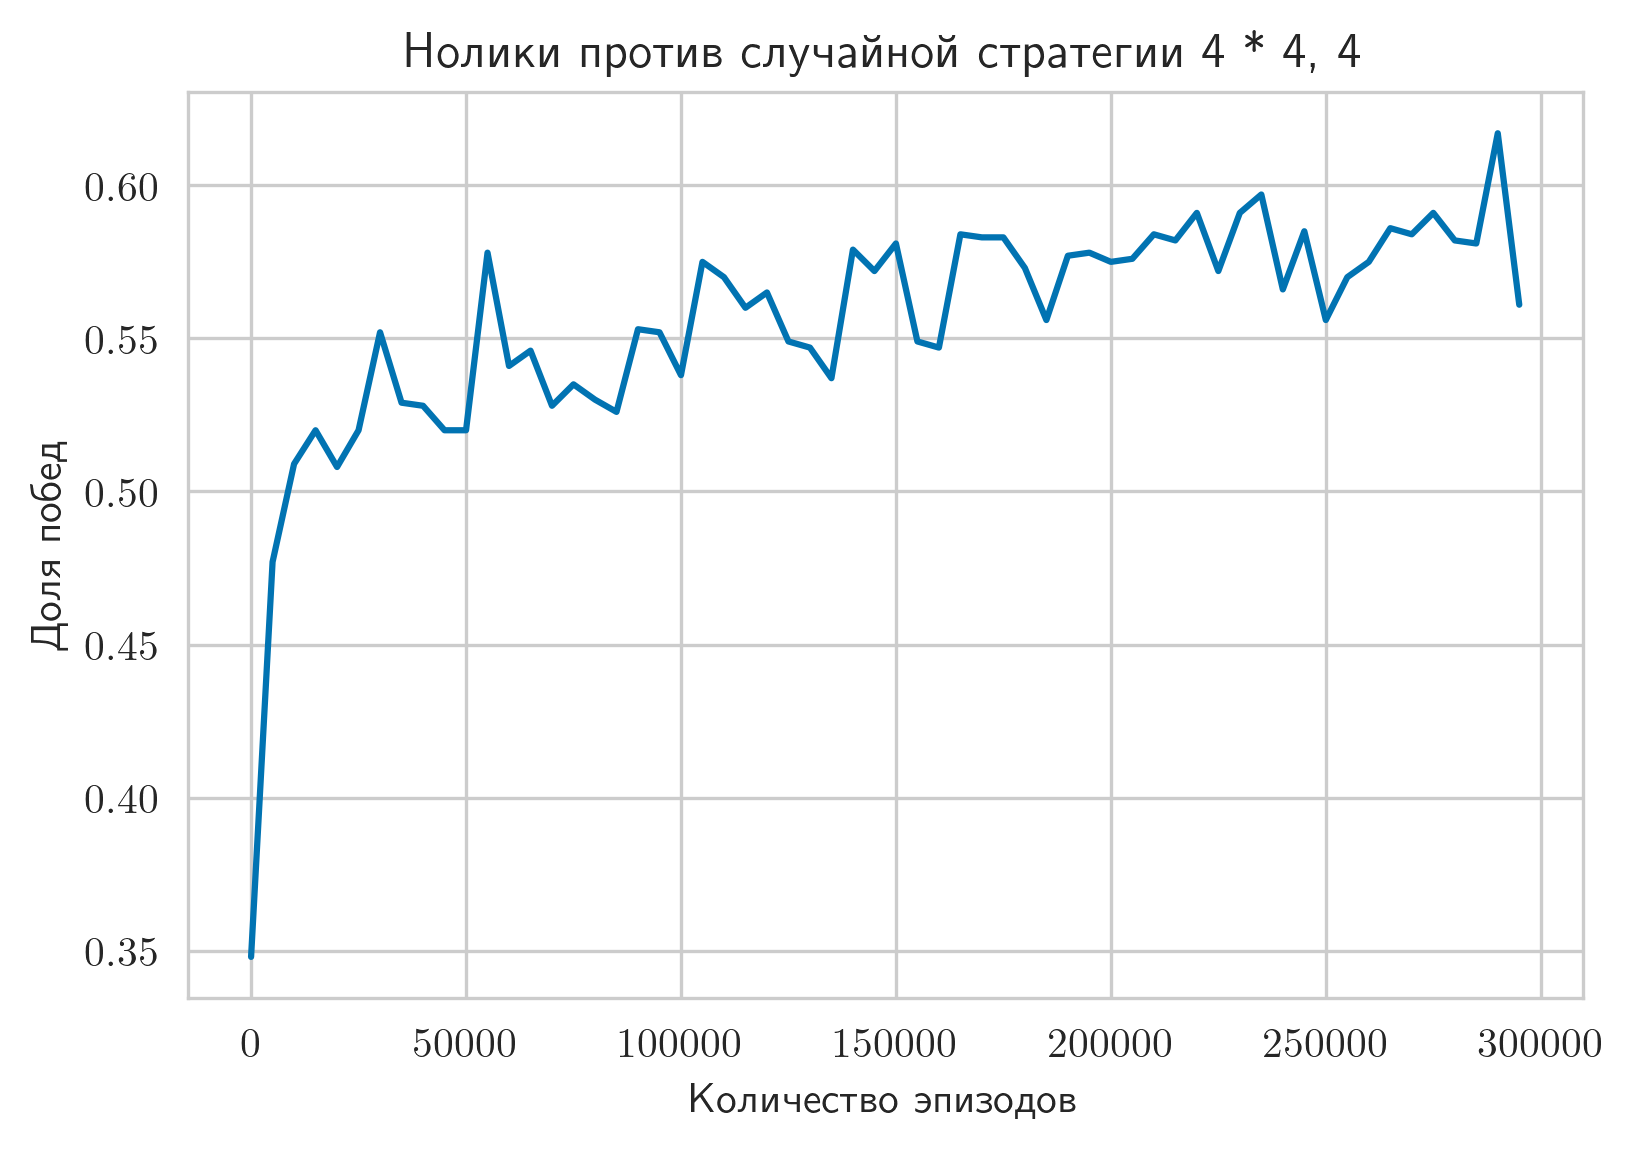

In [37]:
env = TicTacToe(4, 4, 4)
env_name = "4 * 4, 4"
learning(env, env_name, alpha, epsilon, gamma, q_learning_episodes_count, run_experiment_every, experiment_games_count)


## Выводы
Табличное обучение неплохо справляется с доской 3x3, но для доски 4-4 0-кам тяжеле обучатся оптимальной стратегии.

# Часть вторая: добавим нейронных сетей DoubleDQN и DuelingDQN

In [11]:
from turtle import back
from gym import make
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from collections import deque, namedtuple
import random
import copy
from copy import deepcopy

GAMMA = 0.99
BATCH_SIZE = 512
INITIAL_STEPS = 25000
MAX_EPISODES = 1500  # Max number of episodes to play
MAX_STEPS = 1000     # Max steps allowed in a single episode/play
STEPS_PER_UPDATE = 4
STEPS_PER_TARGET_UPDATE = 1

LEARNING_RATE = 5e-5
EPS_START = 0.7      # Default/starting value of eps
EPS_DECAY = 0.999    # Epsilon decay rate
EPS_MIN = 0.01       # Minimum epsilon 
SEED = 42
BUFFER_SIZE = int(1e7)
TAU = 1e-3 

In [13]:

def state_to_array(state):
    return np.array(list(state)).astype(np.int32)

class DQN:

    def __init__(self, state_dim, action_dim):
        self.steps = 0 # Do not change
        self.device = "cpu"#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim)  
        ).to(self.device)
        
        self.target_model = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim)  
        ).to(self.device)
        self.deq =  deque(maxlen=BUFFER_SIZE)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state"])
        self.criterion = nn.MSELoss()
        self.optimizer = Adam(self.model.parameters(), lr=LEARNING_RATE)
        

    
    def consume_transition(self, transition):
        state, action, next_state, reward = transition
        experience = self.experience(state_to_array(state), action, reward, state_to_array(next_state))
        self.deq.append(experience)

    def sample_batch(self):

        experiences = random.sample(self.deq, k=BATCH_SIZE)
        
        states = torch.from_numpy(np.vstack([experience.state for experience in experiences if experience is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([experience.action for experience in experiences if experience is not None])).long().to(self.device)        
        rewards = torch.from_numpy(np.vstack([experience.reward for experience in experiences if experience is not None])).float().to(self.device)        
        next_states = torch.from_numpy(np.vstack([experience.next_state for experience in experiences if experience is not None])).float().to(self.device)  
        
        return (states, actions, rewards, next_states)
    
      

    def train_step(self, batch):
        # Use batch to update DQN's network.

        states, actions, rewards, next_states = batch
        # Get the action with max Q value
        action_values = self.target_model(next_states).detach()
        # Notes
        # tensor.max(1)[0] returns the values, tensor.max(1)[1] will return indices
        # unsqueeze operation --> np.reshape
        # Here, we make it from torch.Size([64]) -> torch.Size([64, 1])
        action_values[states != 1] = -np.inf 
        max_action_values = action_values.max(1)[0].unsqueeze(1)#.argmax(dim=1).unsqueeze(1)
        
        # If done just use reward, else update Q_target with discounted action values
        Q_target = rewards + (GAMMA * max_action_values)
        Q_expected = self.model(states).gather(1, actions)
        
        # Calculate loss
        loss = F.mse_loss(Q_expected, Q_target)
        self.optimizer.zero_grad()
        # backward pass
        loss.backward()
        # update weights
        self.optimizer.step()
        
    def update_target_network(self):
        # Update weights of a target Q-network here. You may use copy.deepcopy to do this or 
        # assign a values of network parameters via PyTorch methods.
        for source_parameters, target_parameters in zip(self.model.parameters(), self.target_model.parameters()):
            target_parameters.data.copy_(TAU * source_parameters.data + (1.0 - TAU) * target_parameters.data)

    def act(self, state, target=False):
        # Compute an action. Do not forget to turn state to a Tensor and then turn an action to a numpy array.
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        # set the network into evaluation mode 
        self.model.eval()
        with torch.no_grad():
            action_values = self.model(state)
        # Back to training mode
        self.model.train()
        action_values[state != 1] = -np.inf 
        action = action_values.argmax(dim=1).unsqueeze(1)
        return action    

    def update(self, transition):
        # You don't need to change this
        self.consume_transition(transition)
        if self.steps % STEPS_PER_UPDATE == 0:
            batch = self.sample_batch()
            self.train_step(batch)
        if self.steps % STEPS_PER_TARGET_UPDATE == 0:
            self.update_target_network()
        self.steps += 1

        
class RandomAgent:
    def act(self, state):
        return np.random.choice([i for i,x in enumerate(state) if x == 1])
    
        
def validate_dqn(env, dqn_agent, name, n_episodes):
    # validate against random agent
    if name == 'o':
        agents = { 
            1: RandomAgent(), -1: dqn_agent
        }
    else:
        agents = {
            1: dqn_agent, -1: RandomAgent()
        }
    all_rewards = []
    
    for _ in range(n_episodes):
        env.reset()
        state, empty_cells, turn = env.getState()
        done = False
        while not done:

            action = agents[turn].act(state_to_array(state))
            (state, empty_cells, turn), reward, done, _ = env.step(env.action_from_int(action))
        all_rewards.append(reward)
    
    return all_rewards

def generate_expirense(x_agent, o_agent, steps):
    for _ in range(steps):
        env.reset()        
        state, empty_cells, turn = env.getState()
        done = False
        exp_collection = []
        reward = None
        while not done:

            action = empty_cells[np.random.randint(0, len(empty_cells))]


            (next_state, empty_cells, turn), reward, done, _ = env.step(action)

            exp_collection.append((state, env.int_from_action(action), next_state, reward))
            state = next_state
        if reward == 1:
            for state, action, next_state, reward in exp_collection:
                x_agent.consume_transition((state, action, next_state, reward))
        elif reward == -1:
            for state, action, next_state, reward in exp_collection:
                o_agent.consume_transition((state, action, next_state, -reward))

    return x_agent, o_agent

def train(x_agent, o_agent, max_episodes, max_steps, eps_decay, eps_min, ):
    x_wins_collection = []
    o_wins_collection = []
    for i in range(max_episodes):
        state = env.reset()
        state, empty_cells, turn = env.getState()
        done = False
        #action = empty_cells[np.random.randint(0, len(empty_cells))]
        for j in range(max_steps):
            while not done:


                if random.random() < eps:   
                    action = np.random.randint(0, len(empty_cells))
                else:
                    if turn == 1:
                        action = x_agent.act(state_to_array(state))
                    else:
                        action = o_agent.act(state_to_array(state))

                (next_state, empty_cells, turn), reward, done, _ = env.step(env.action_from_int(action))

                if turn == 1:
                    x_agent.update((state, action, next_state, reward))
                else:
                    o_agent.update((state, action, next_state, -reward))

                state = next_state
        eps = max(eps * eps_decay, eps_min)



        if (i + 1) % (max_episodes // 100) == 0:
            rewards_x = validate_dqn(env, x_agent, 'x', 1000)
            x_wins = np.sum(np.array(rewards_x) == 1) / len(rewards_x)
            rewards_o = validate_dqn(env, o_agent, 'o', 1000)
            o_wins = np.sum(np.array(rewards_o) == -1) / len(rewards_o)
            x_wins_collection.append(x_wins)
            o_wins_collection.append(o_wins)
            if (i + 1) % (max_episodes // 10) == 0:
                print(f"Доля побед крестиков {x_wins}, Доля побед ноликов {o_wins}")
    return x_wins_collection, o_wins_collection

In [618]:


env.seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
nrow=3
ncol=3
nwins=3
env = TicTacToe(nrow, ncol, nwins)
observation_space = nrow*ncol
action_space = nrow*ncol
x_agent = DQN(state_dim=observation_space, action_dim=action_space)
o_agent = DQN(state_dim=observation_space, action_dim=action_space)
eps = EPS_START
state = env.reset()
x_agent, o_agent = generate_expirense(x_agent, o_agent, INITIAL_STEPS) # сэмплирую опыт, 
#стараюсь сразу сэмплировать оптыт для крестиков,
#где крестики выигрывают, а для ноликов партии в которых нолики выигрывают



In [626]:
x_wins_collection, o_wins_collection = train(x_agent, o_agent, MAX_EPISODES, MAX_STEPS, EPS_DECAY, EPS_MIN, eps)

Доля побед крестиков 0.708, Доля побед ноликов 0.279
Доля побед крестиков 0.677, Доля побед ноликов 0.327
Доля побед крестиков 0.669, Доля побед ноликов 0.466
Доля побед крестиков 0.849, Доля побед ноликов 0.576
Доля побед крестиков 0.908, Доля побед ноликов 0.712
Доля побед крестиков 0.892, Доля побед ноликов 0.693
Доля побед крестиков 0.892, Доля побед ноликов 0.693
Доля побед крестиков 0.867, Доля побед ноликов 0.669
Доля побед крестиков 0.912, Доля побед ноликов 0.605
Доля побед крестиков 0.838, Доля побед ноликов 0.614


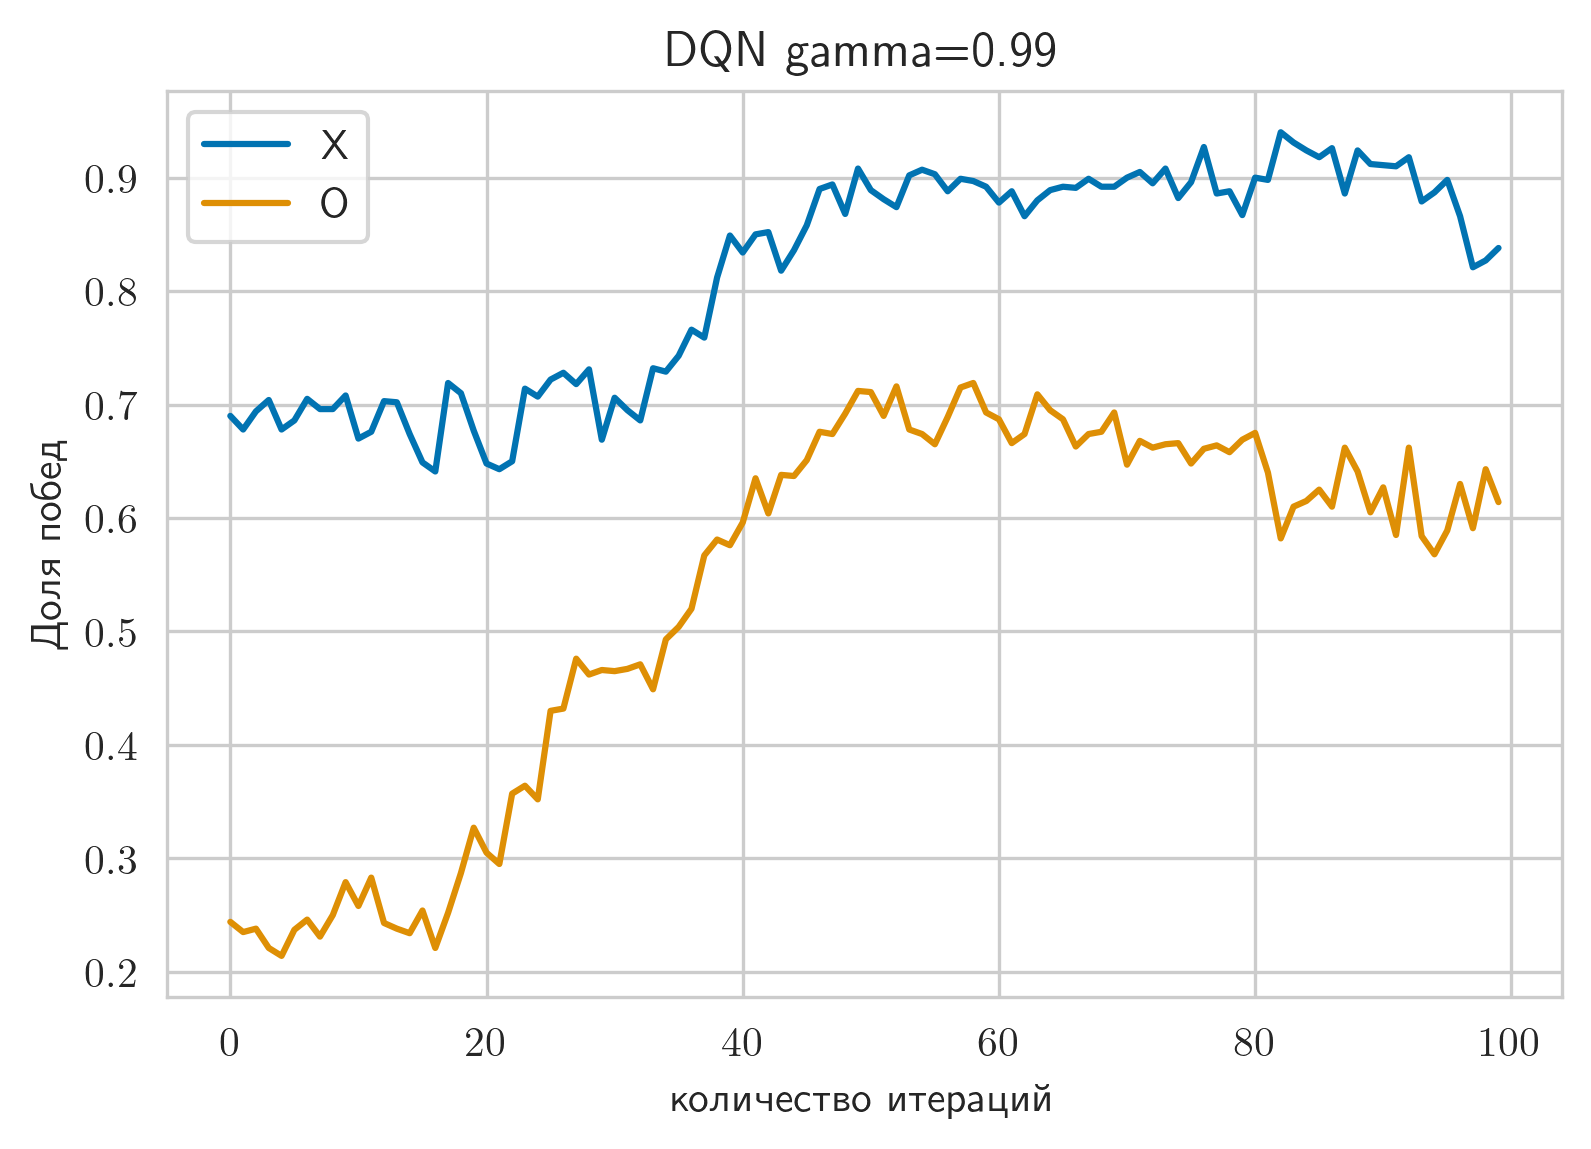

In [627]:
plt.plot(x_wins_collection, label='X')
plt.plot(o_wins_collection, label='O')
plt.title(f'DQN gamma={GAMMA} размер поля {nrow}x{ncol}')
plt.xlabel('количество итераций')
plt.ylabel('Доля побед')
plt.legend()
plt.show()

In [628]:
nrow=4
ncol=4
nwins=4
env = TicTacToe(nrow, ncol, nwins)

observation_space = nrow * ncol
action_space = nrow * ncol
env.seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
x_agent = DQN(state_dim=observation_space, action_dim=action_space)
o_agent = DQN(state_dim=observation_space, action_dim=action_space)
eps = EPS_START
state = env.reset()

x_agent, o_agent = generate_expirense(x_agent, o_agent, INITIAL_STEPS)

In [629]:
x_wins_collection, o_wins_collection = train(x_agent, o_agent, MAX_EPISODES, MAX_STEPS, EPS_DECAY, EPS_MIN, eps)

Доля побед крестиков 0.185, Доля побед ноликов 0.357
Доля побед крестиков 0.312, Доля побед ноликов 0.282
Доля побед крестиков 0.404, Доля побед ноликов 0.359
Доля побед крестиков 0.467, Доля побед ноликов 0.428
Доля побед крестиков 0.672, Доля побед ноликов 0.427
Доля побед крестиков 0.72, Доля побед ноликов 0.41
Доля побед крестиков 0.7, Доля побед ноликов 0.429
Доля побед крестиков 0.674, Доля побед ноликов 0.445
Доля побед крестиков 0.715, Доля побед ноликов 0.479
Доля побед крестиков 0.755, Доля побед ноликов 0.473


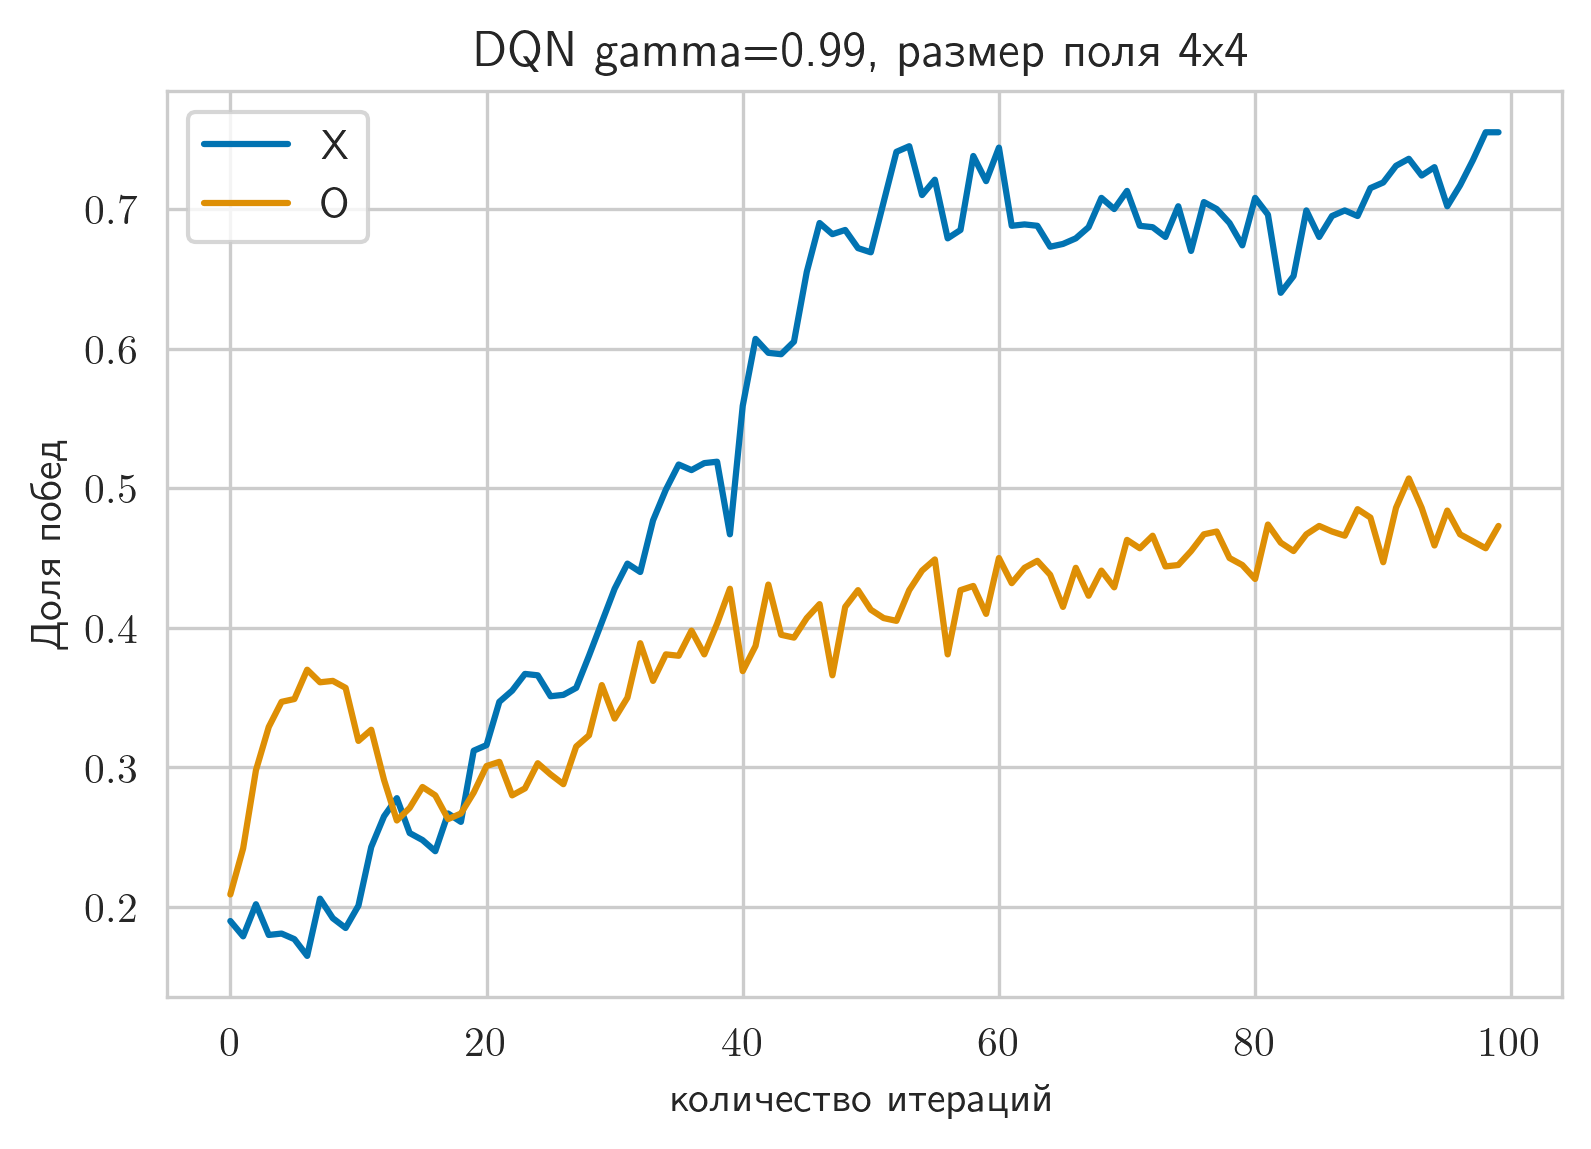

In [631]:
plt.plot(x_wins_collection, label='X')
plt.plot(o_wins_collection, label='O')
plt.title(f'DQN gamma={GAMMA}, размер поля {nrow}x{ncol}')
plt.xlabel('количество итераций')
plt.ylabel('Доля побед')
plt.legend()
plt.show()

## Выводы
Как видно из графиков, для размера доски 4x4 обучения проходит медленнее, так же была проблема с обученем стратегии для 0-ков, она заключалось в том, что очень мало случайных партий где 0-ки выигрывают, поэтому, буфер агента для 0-ков заполнял только партиями где 0-ки выйграли.

## DuelingDQN

In [632]:
class DuelingDQNet(nn.Module):
    "Duieling DQN architecture"
    def __init__(self, input_dim, output_dim):
        super(DuelingDQNet, self).__init__()

        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc_adv = nn.Linear(32, output_dim)
        self.fc_val = nn.Linear(32, 1)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        adv = self.fc_adv(x)
        val = self.fc_val(x)
        return val + (adv - adv.mean())

In [633]:
class DuelingDQN:

    def __init__(self, state_dim, action_dim):
        self.steps = 0 # Do not change
        self.device = "cpu"#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = DuelingDQNet(state_dim, action_dim).to(self.device)
        
        self.target_model = DuelingDQNet(state_dim, action_dim).to(self.device)
        self.deq =  deque(maxlen=BUFFER_SIZE)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state"])
        self.criterion = nn.MSELoss()
        self.optimizer = Adam(self.model.parameters(), lr=LEARNING_RATE)
        

    
    def consume_transition(self, transition):
        state, action, next_state, reward = transition
        experience = self.experience(state_to_array(state), action, reward, state_to_array(next_state))
        self.deq.append(experience)

    def sample_batch(self):

        experiences = random.sample(self.deq, k=BATCH_SIZE)
        
        states = torch.from_numpy(np.vstack([experience.state for experience in experiences if experience is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([experience.action for experience in experiences if experience is not None])).long().to(self.device)        
        rewards = torch.from_numpy(np.vstack([experience.reward for experience in experiences if experience is not None])).float().to(self.device)        
        next_states = torch.from_numpy(np.vstack([experience.next_state for experience in experiences if experience is not None])).float().to(self.device)  
        
        return (states, actions, rewards, next_states)
    
      

    def train_step(self, batch):
        # Use batch to update DQN's network.

        states, actions, rewards, next_states = batch
        # Get the action with max Q value
        action_values = self.target_model(next_states).detach()
        # Notes
        # tensor.max(1)[0] returns the values, tensor.max(1)[1] will return indices
        # unsqueeze operation --> np.reshape
        # Here, we make it from torch.Size([64]) -> torch.Size([64, 1])
        action_values[states != 1] = -np.inf 
        max_action_values = action_values.max(1)[0].unsqueeze(1)#.argmax(dim=1).unsqueeze(1)
        
        # If done just use reward, else update Q_target with discounted action values
        Q_target = rewards + (GAMMA * max_action_values)
        Q_expected = self.model(states).gather(1, actions)
        
        # Calculate loss
        loss = F.mse_loss(Q_expected, Q_target)
        self.optimizer.zero_grad()
        # backward pass
        loss.backward()
        # update weights
        self.optimizer.step()
        
    def update_target_network(self):
        # Update weights of a target Q-network here. You may use copy.deepcopy to do this or 
        # assign a values of network parameters via PyTorch methods.
        for source_parameters, target_parameters in zip(self.model.parameters(), self.target_model.parameters()):
            target_parameters.data.copy_(TAU * source_parameters.data + (1.0 - TAU) * target_parameters.data)

    def act(self, state, target=False):
        # Compute an action. Do not forget to turn state to a Tensor and then turn an action to a numpy array.
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        # set the network into evaluation mode 
        self.model.eval()
        with torch.no_grad():
            action_values = self.model(state)
        # Back to training mode
        self.model.train()
        action_values[state != 1] = -np.inf 
        action = action_values.argmax(dim=1).unsqueeze(1)
        return action    

    def update(self, transition):
        # You don't need to change this
        self.consume_transition(transition)
        if self.steps % STEPS_PER_UPDATE == 0:
            batch = self.sample_batch()
            self.train_step(batch)
        if self.steps % STEPS_PER_TARGET_UPDATE == 0:
            self.update_target_network()
        self.steps += 1


In [634]:
nrow=3
ncol=3
nwins=3
env = TicTacToe(nrow, ncol, nwins)
observation_space = nrow*ncol
action_space = nrow*ncol
x_agent = DuelingDQN(state_dim=observation_space, action_dim=action_space)
o_agent = DuelingDQN(state_dim=observation_space, action_dim=action_space)
eps = EPS_START
state = env.reset()

In [635]:
x_agent, o_agent = generate_expirense(x_agent, o_agent, INITIAL_STEPS)
x_wins_collection, o_wins_collection = train(x_agent, o_agent, MAX_EPISODES, MAX_STEPS, EPS_DECAY, EPS_MIN, eps)

Доля побед крестиков 0.515, Доля побед ноликов 0.393
Доля побед крестиков 0.773, Доля побед ноликов 0.578
Доля побед крестиков 0.872, Доля побед ноликов 0.667
Доля побед крестиков 0.877, Доля побед ноликов 0.623
Доля побед крестиков 0.907, Доля побед ноликов 0.586
Доля побед крестиков 0.883, Доля побед ноликов 0.608
Доля побед крестиков 0.876, Доля побед ноликов 0.611
Доля побед крестиков 0.814, Доля побед ноликов 0.595
Доля побед крестиков 0.8, Доля побед ноликов 0.602
Доля побед крестиков 0.801, Доля побед ноликов 0.579


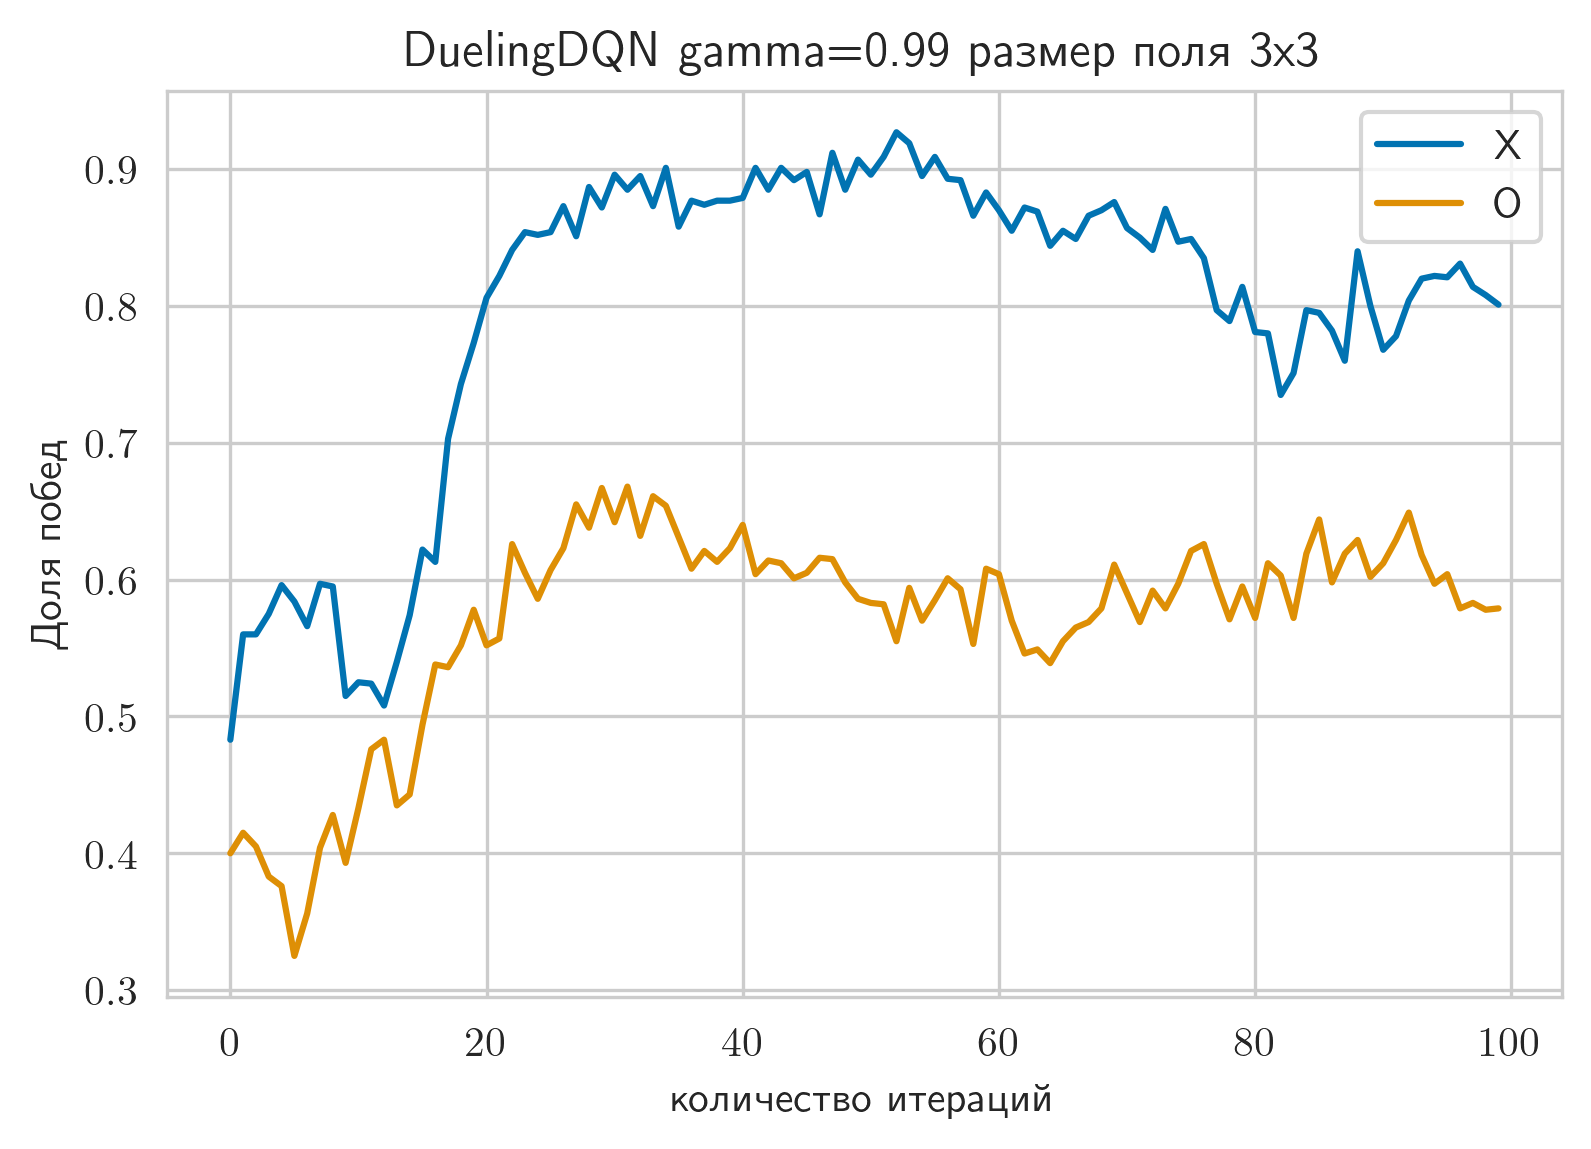

In [636]:
plt.plot(x_wins_collection, label='X')
plt.plot(o_wins_collection, label='O')
plt.title(f'DuelingDQN gamma={GAMMA} размер поля {nrow}x{ncol}')
plt.xlabel('количество итераций')
plt.ylabel('Доля побед')
plt.legend()
plt.show()

In [637]:
nrow=4
ncol=4
nwins=4
env = TicTacToe(nrow, ncol, nwins)
observation_space = nrow*ncol
action_space = nrow*ncol
x_agent = DuelingDQN(state_dim=observation_space, action_dim=action_space)
o_agent = DuelingDQN(state_dim=observation_space, action_dim=action_space)
eps = EPS_START
state = env.reset()

In [638]:
x_agent, o_agent = generate_expirense(x_agent, o_agent, INITIAL_STEPS)
x_wins_collection, o_wins_collection = train(x_agent, o_agent, MAX_EPISODES, MAX_STEPS, EPS_DECAY, EPS_MIN, eps)

Доля побед крестиков 0.163, Доля побед ноликов 0.21
Доля побед крестиков 0.294, Доля побед ноликов 0.298
Доля побед крестиков 0.461, Доля побед ноликов 0.34
Доля побед крестиков 0.594, Доля побед ноликов 0.435
Доля побед крестиков 0.696, Доля побед ноликов 0.477
Доля побед крестиков 0.649, Доля побед ноликов 0.523
Доля побед крестиков 0.62, Доля побед ноликов 0.499
Доля побед крестиков 0.591, Доля побед ноликов 0.556
Доля побед крестиков 0.62, Доля побед ноликов 0.556
Доля побед крестиков 0.689, Доля побед ноликов 0.578


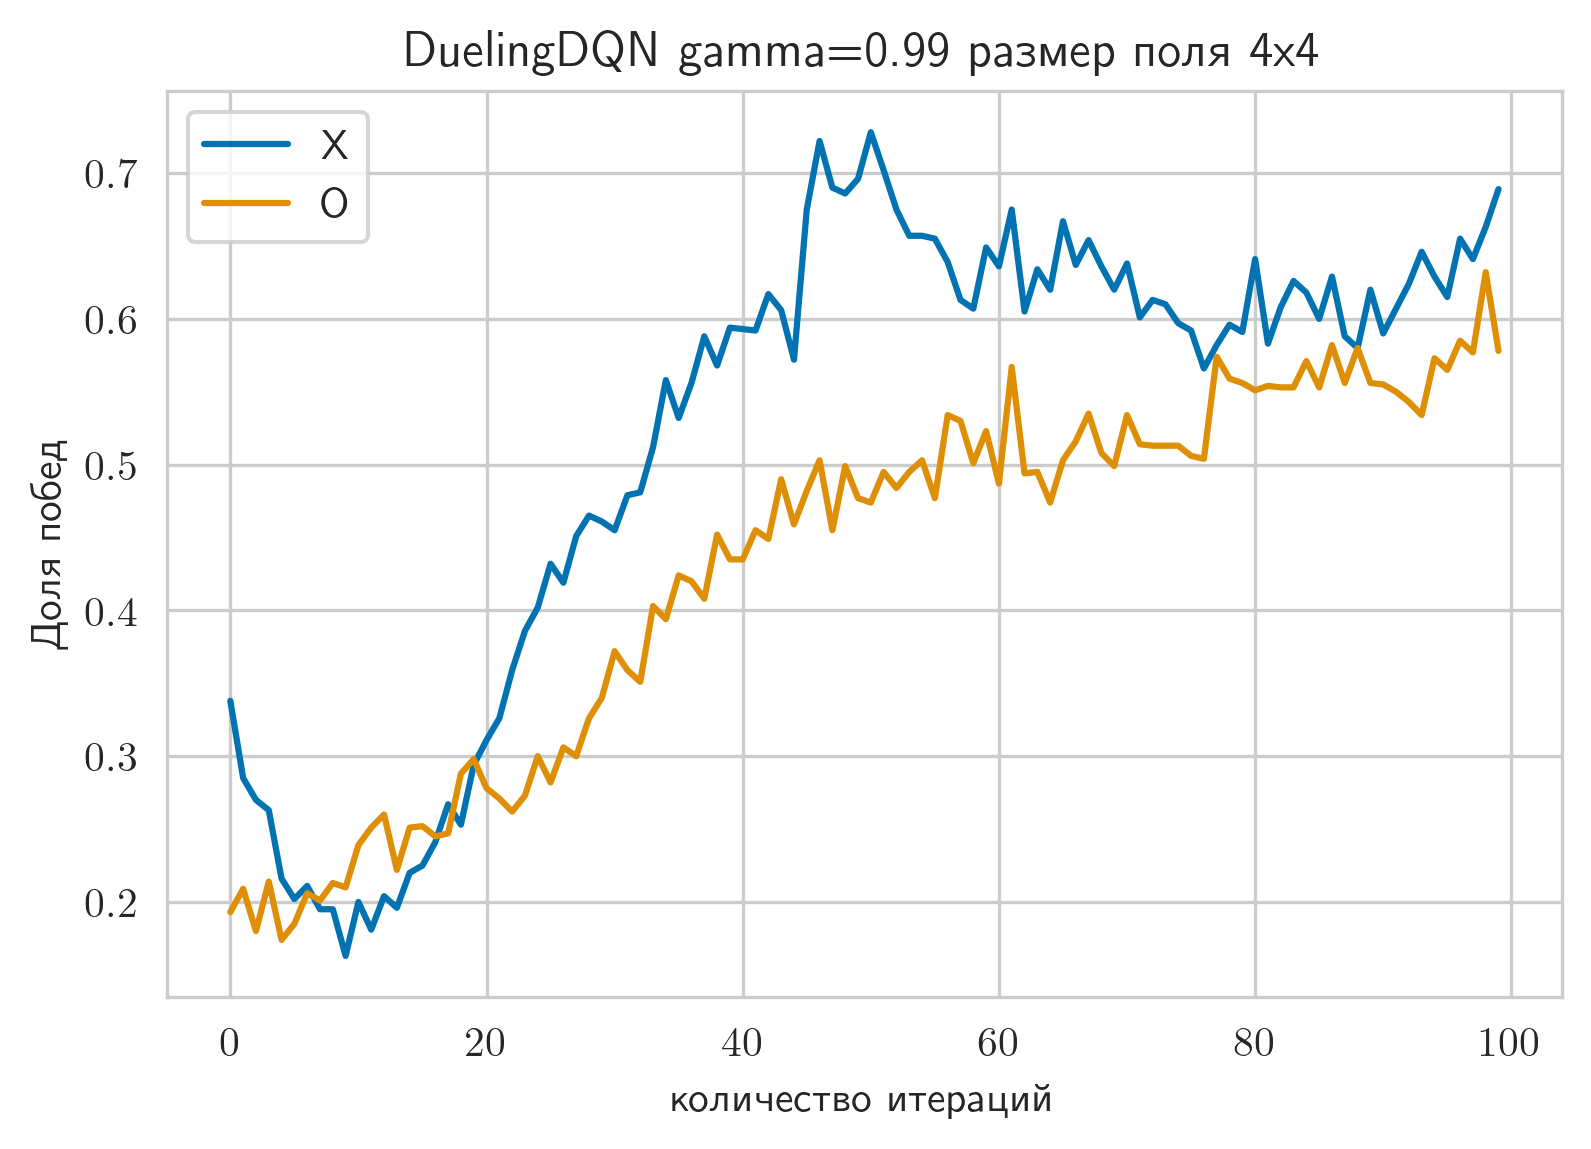

In [639]:
plt.plot(x_wins_collection, label='X')
plt.plot(o_wins_collection, label='O')
plt.title(f'DuelingDQN gamma={GAMMA} размер поля {nrow}x{ncol}')
plt.xlabel('количество итераций')
plt.ylabel('Доля побед')
plt.legend()
plt.show()

## Выводы
Как видно из графиков, DuelingDQN быстрее сходится к оптимальной стратегии чем DoubleDQN

In [9]:
class Rollout:
    def __init__(self, env, n_rollouts, side):
        self.env = env
        self.opp_agent = RandomAgent()
        self.side = side
        self.n_rollouts = n_rollouts
        
    def make_rollout(self, env):
        roll_env = deepcopy(env)
        state, empty_cells, turn = roll_env.getState()
        roll_side = -turn
        done = False
        while not done:
            action = self.opp_agent.act(state_to_array(state))
            (state, empty_cells, turn), reward, done, _ = roll_env.step(env.action_from_int(action))
        return reward * roll_side

    def eval_by_rollouts(self):
        state, empty_cells, turn = self.env.getState()
        curr_side = turn
        action_estimates = {}
        for action in [i for i,x in enumerate(state) if x == "1"]:
            curr_env = deepcopy(self.env)
            (state, empty_cells, turn), reward, done, _ = curr_env.step(curr_env.action_from_int(action))
            if done:
                action_estimates[action] = reward * curr_side
            else:
                action_estimates[action] = np.mean([self.make_rollout(curr_env) for _ in range(self.n_rollouts)])
        
        return max(action_estimates, key=action_estimates.get)
    
    def run_episode(self):
        self.env.reset()
        state, empty_cells, turn = self.env.getState()
        done = False
        while not done:
            if self.side == 'x':
                action = self.eval_by_rollouts() if turn == 1 \
                else self.opp_agent.act(state_to_array(state))
            else:
                action = self.eval_by_rollouts() if turn == -1 \
                else self.opp_agent.act(state_to_array(state))
            (state, empty_cells, turn), reward, done, _ = self.env.step(self.env.action_from_int(action))
            
        return reward

100%|█████████████████████████████████████████| 800/800 [01:26<00:00,  9.23it/s]


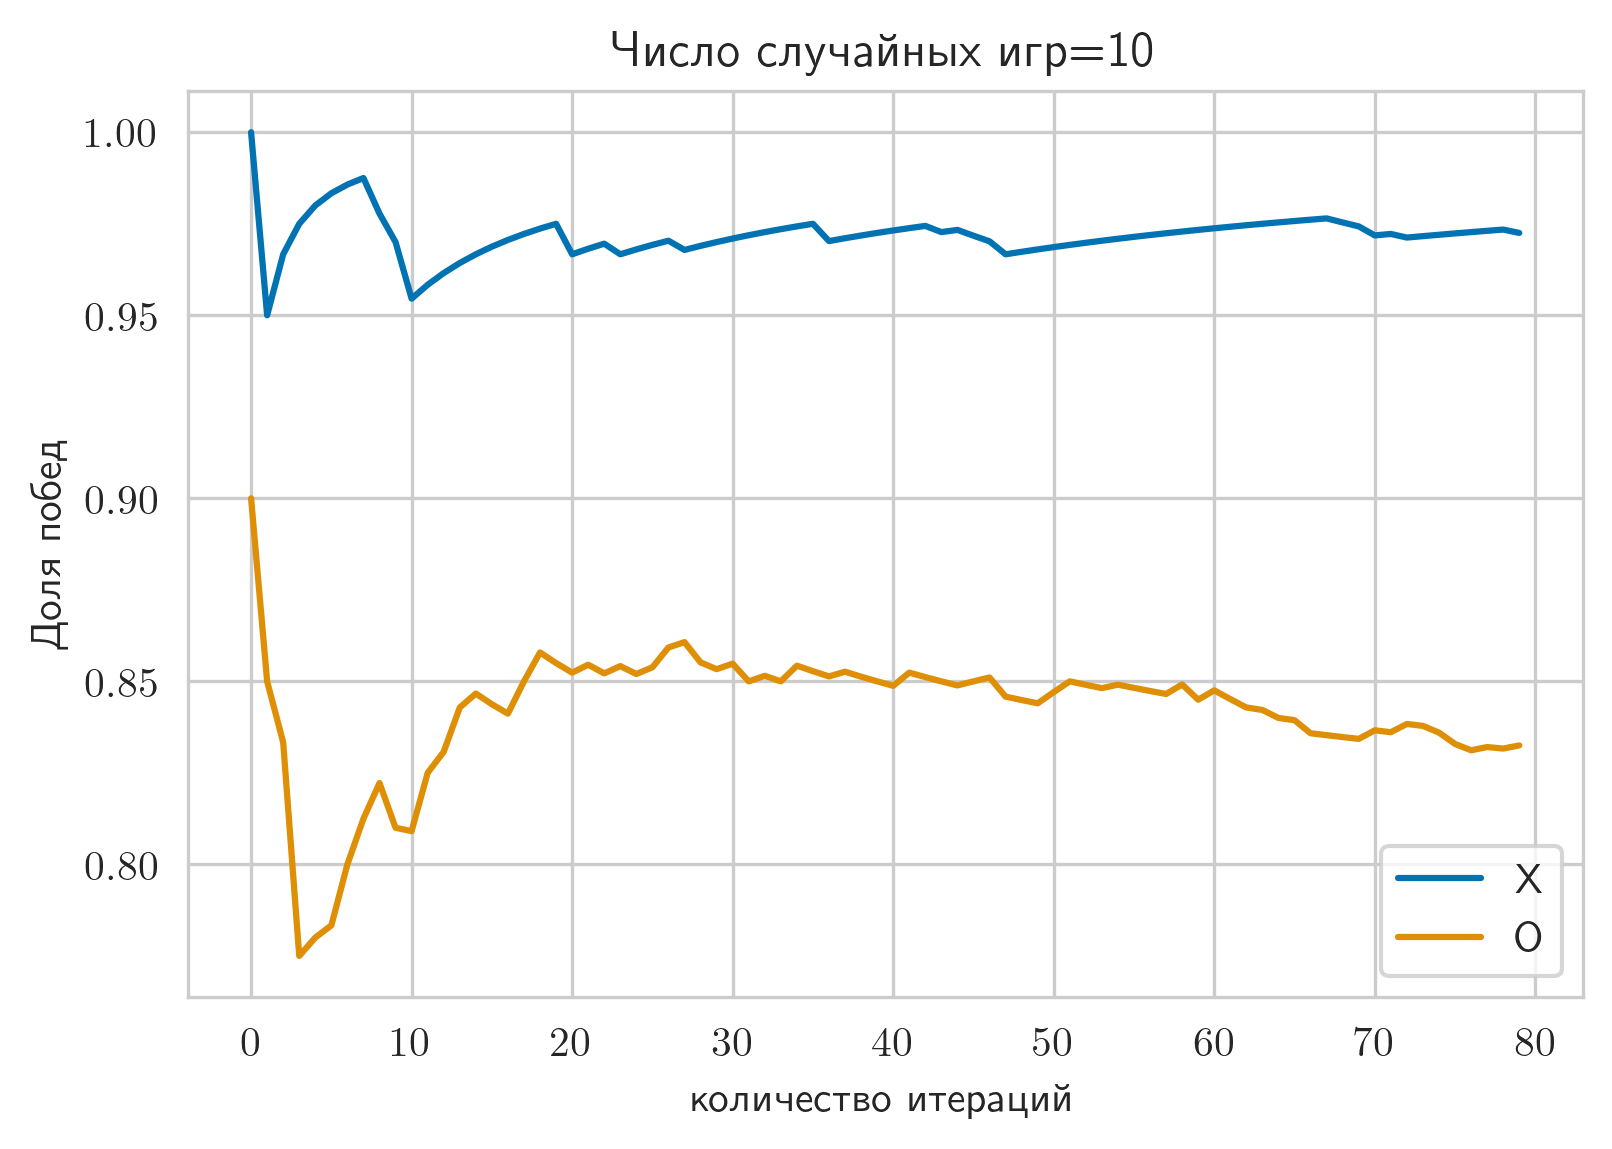

In [16]:
game_count = 10
x_agent = Rollout(TicTacToe(3, 3, 3), game_count, 'x')
o_agent = Rollout(TicTacToe(3, 3, 3), game_count, 'o')
rewards_x, rewards_o = [], []
x_wins_collection, o_wins_collection = [], []
N_EPOCHS = 800

for i in tqdm(range(N_EPOCHS)):
    reward_x = x_agent.run_episode()
    reward_o = o_agent.run_episode()
    rewards_x.append(reward_x)
    rewards_o.append(reward_o)

    if (i + 1) % 10 == 0:
        x_wins = np.sum(np.array(rewards_x) == 1) / len(rewards_x)
        o_wins = np.sum(np.array(rewards_o) == -1) / len(rewards_o)
        x_wins_collection.append(x_wins)
        o_wins_collection.append(o_wins)

plt.plot(x_wins_collection, label='X')
plt.plot(o_wins_collection, label='O')
plt.title(f'Число случайных игр={game_count}')
plt.xlabel('количество итераций')
plt.ylabel('Доля побед')
plt.legend()
plt.show()



100%|█████████████████████████████████████████| 800/800 [26:26<00:00,  1.98s/it]


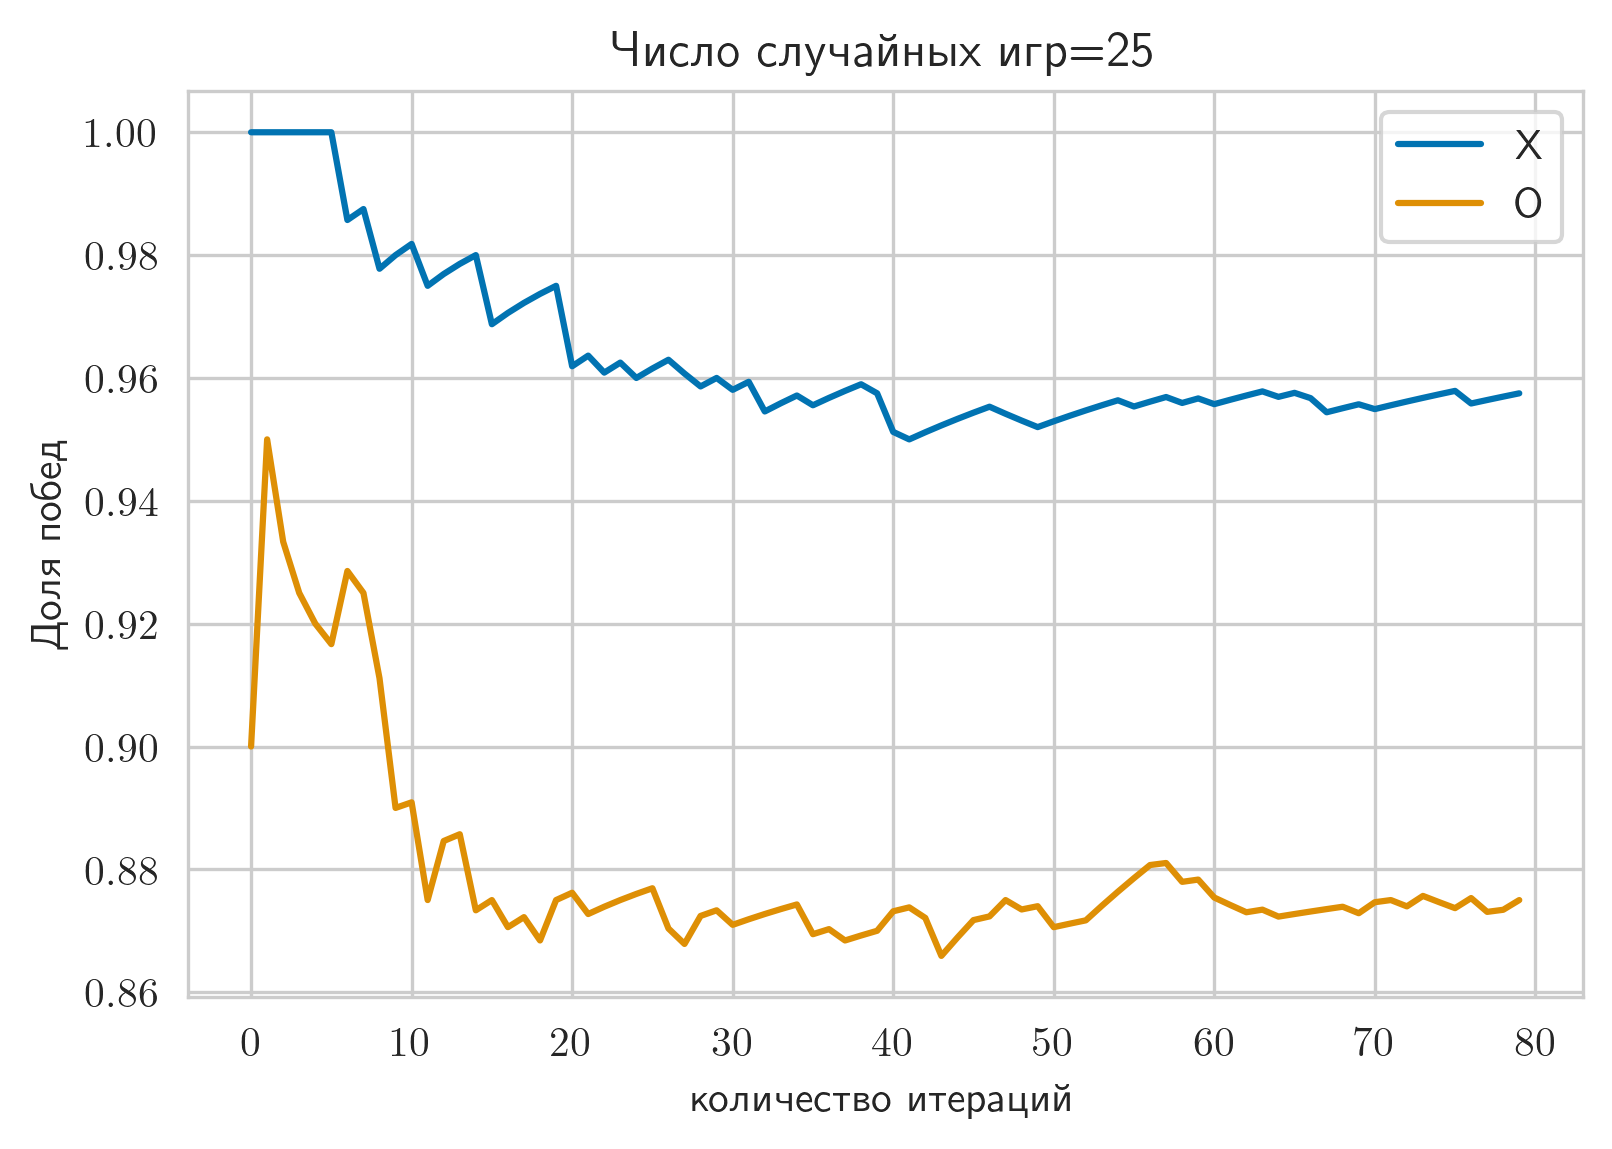

In [17]:
game_count = 25
x_agent = Rollout(TicTacToe(4, 4, 4), game_count, 'x')
o_agent = Rollout(TicTacToe(4, 4, 4), game_count, 'o')
rewards_x, rewards_o = [], []
x_wins_collection, o_wins_collection = [], []
N_EPOCHS = 800

for i in tqdm(range(N_EPOCHS)):
    reward_x = x_agent.run_episode()
    reward_o = o_agent.run_episode()
    rewards_x.append(reward_x)
    rewards_o.append(reward_o)

    if (i + 1) % 10 == 0:
        x_wins = np.sum(np.array(rewards_x) == 1) / len(rewards_x)
        o_wins = np.sum(np.array(rewards_o) == -1) / len(rewards_o)
        x_wins_collection.append(x_wins)
        o_wins_collection.append(o_wins)

plt.plot(x_wins_collection, label='X')
plt.plot(o_wins_collection, label='O')
plt.title(f'Число случайных игр={game_count}')
plt.xlabel('количество итераций')
plt.ylabel('Доля побед')
plt.legend()
plt.show()



In [24]:
from collections import defaultdict
class MCTS:
    "Monte Carlo Tree Search"
    def __init__(self, env, side='x', exploration_weight=1):
        self.env = env
        self.Q = defaultdict(int)  # сумарная награда для каждого узла
        self.N = defaultdict(int)  # количесво посещений каждой вершины
        self.children = dict()  # дети каждого узла
        self.C = exploration_weight
        self.side = 1 if side == 'x' else -1
        
    def act(self, node1, node2):
        return np.argwhere(
            np.array(list(node1)).reshape(self.env.n_rows, self.env.n_cols) 
            != np.array(list(node2)).reshape(self.env.n_rows, self.env.n_cols)
        ).flatten()
    
    def uct_select(self, node):
        "Выбор следующего узла, trade-off между exploration и exploitation"
        log_N_vertex = math.log(self.N[node])
        uct = []
        for child in self.children[node]:
            uct.append(self.Q[child] / self.N[child] + self.C * math.sqrt(log_N_vertex / self.N[child]))
        return self.children[node][np.argmax(uct)]
    
    def select_node(self, node):
        "Поиск неизведанных узлов"
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                # node is either unexplored or terminal
                return path
            for child in self.children[node]:
                if child not in self.N:
                    # select first unexplored child
                    action = self.act(node, child)
                    path.append(child)
                    self.env.step(action)
                    return path
            if self.side == self.env.curTurn:
                # continue selecting by UCT
                child = self.uct_select(node)
                action = self.act(node, child)
            else:
                # opposite agent makes random action
                action = random.choice(self.env.getEmptySpaces())
            (node, _, _), _, _, _ = self.env.step(action)
    
    def expand(self):
        "Update the `children` dict with the children of `node`"
        node, empty_cells, turn = self.env.getState()
        if node in self.children:
            return  # already expanded
        children = []
        if not self.env.gameOver:
            for action in empty_cells:
                self.env.makeMove(turn, action[0], action[1])
                children.append(self.env.getHash())
                self.env.makeMove(0, action[0], action[1])

        self.children[node] = children
    
    def backprop(self, path, reward):
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward
            reward = 1 - reward # inverse for enemy
    
    def make_rollout(self):
        if self.env.gameOver:
            self.env.curTurn = -self.env.curTurn
            reward = self.env.isTerminal()
            return int(reward * self.env.curTurn > 0), True
        
        env = deepcopy(self.env)
        _, empty_cells, turn = env.getState()
        done = False
        while not done:
            action = random.choice(empty_cells)
            (_, empty_cells, _), reward, done, _ = env.step(action)
        
        fin_reward = None
        if turn == 1:
            fin_reward = 0 if reward >= 0 else 1
        elif turn == -1:
            fin_reward = 0 if reward <= 0 else 1
        return fin_reward, False

    def select_best_action(self):
        "Жадный выбор действия"
        node, empty_cells, _ = self.env.getState()
        
        if node not in self.children:
            return random.choice(empty_cells)
        
        # get mean Q for each available action
        q_vals = []
#         print('select from', self.children[node])
        for child in self.children[node]:
            if child not in self.N:
                q_vals.append(-np.inf)
            else:
                q_vals.append(self.Q[child] / self.N[child])
        return empty_cells[np.argmax(q_vals)]
    
    def learn(self, n_episodes):
        for _ in range(n_episodes):
            self.env.reset()
            done = False
            path = []
            while not done:
                node, _, _ = self.env.getState()
                curr_path = self.select_node(node)
                path += curr_path
                self.expand()
                reward, done = self.make_rollout()
                self.backprop(path, reward)
                path = path[:-1]
    
    def validate(self, n_episodes):
        all_rewards = []
        for _ in range(n_episodes):
            self.env.reset()
            state, empty_cells, turn = self.env.getState()
            done = False
            while not done:
                if (turn == 1 and self.side == 1) or (turn == -1 and self.side == -1):
                    action = self.select_best_action()
                else:
                    action = random.choice(empty_cells)
                
                (state, empty_cells, turn), reward, done, _ = self.env.step(action)
            if reward == -10:
                print(state, empty_cells)
                raise ValueError('')
            fin_reward = reward if self.side == 1 else -reward
            all_rewards.append(fin_reward)
        return all_rewards

100%|███████████████████████████████████████████| 40/40 [00:26<00:00,  1.51it/s]


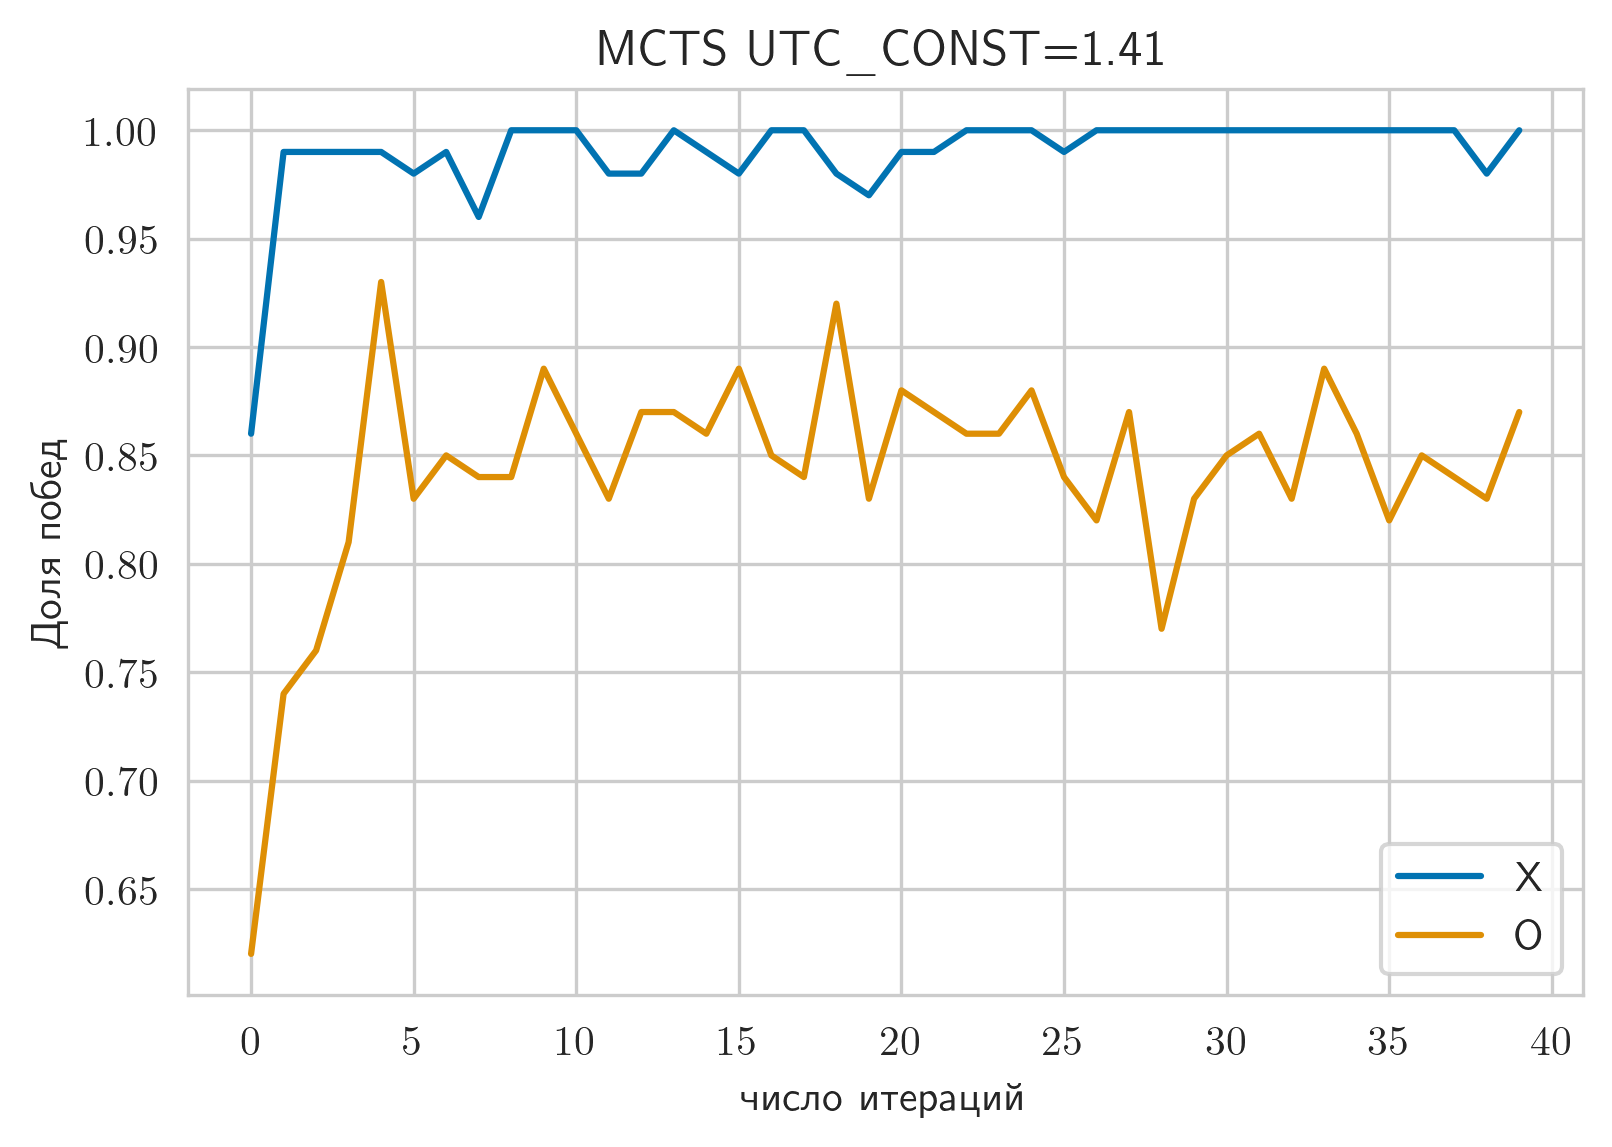

In [26]:


N_EPOCHS = 40
UTC_CONST = math.sqrt(2)

x_agent = MCTS(TicTacToe(3, 3, 3), 'x', UTC_CONST)
o_agent = MCTS(TicTacToe(3, 3, 3), 'o', UTC_CONST)
x_wins_collection, o_wins_collection = [], []

for _ in tqdm(range(N_EPOCHS)):
    x_agent.learn(1_000)
    o_agent.learn(1_000)
    rewards_x = x_agent.validate(100)
    x_wins = np.sum(np.array(rewards_x) == 1) / len(rewards_x)
    rewards_o = o_agent.validate(100)
    o_wins = np.sum(np.array(rewards_o) == 1) / len(rewards_o)
    x_wins_collection.append(x_wins)
    o_wins_collection.append(o_wins)

plt.plot(x_wins_collection, label='X')
plt.plot(o_wins_collection, label='O')
plt.title(f'MCTS UTC_CONST={round(UTC_CONST,2)}')
plt.xlabel('число итераций')
plt.ylabel('Доля побед')
plt.legend()
plt.show()



100%|█████████████████████████████████████████| 400/400 [29:11<00:00,  4.38s/it]


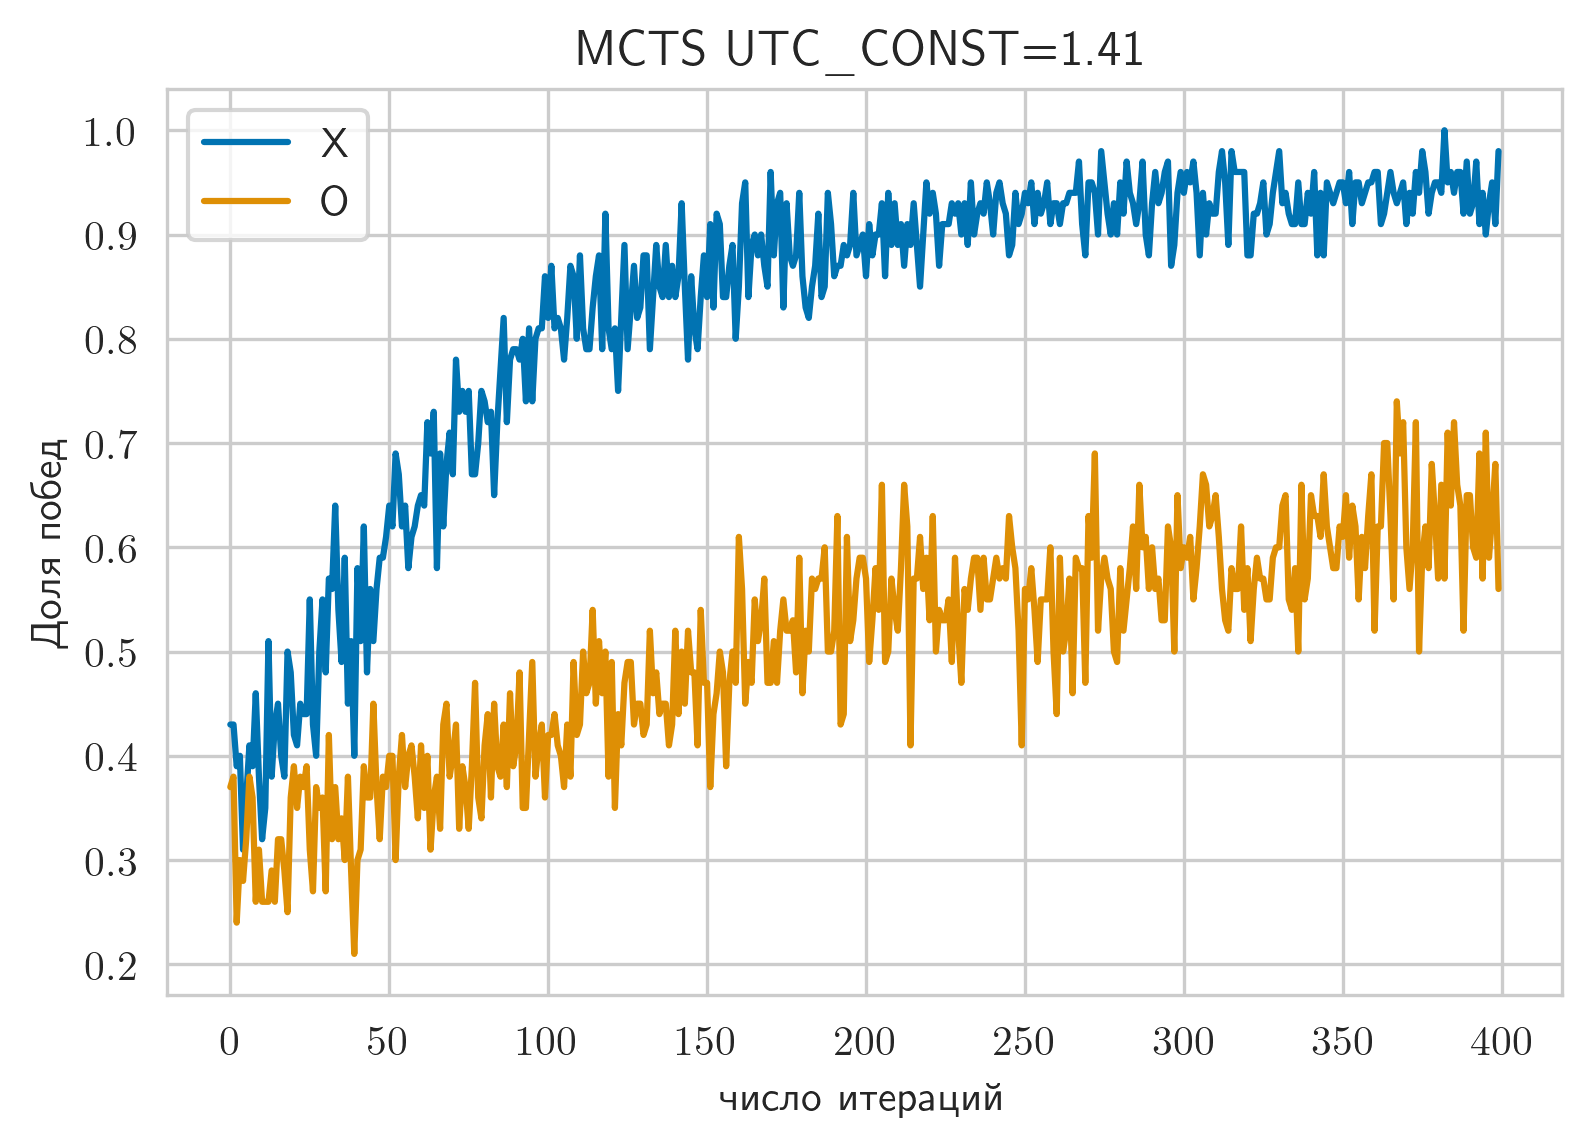

In [28]:



N_EPOCHS = 400
UTC_CONST = math.sqrt(2)

x_agent = MCTS(TicTacToe(4, 4, 4), 'x', UTC_CONST)
o_agent = MCTS(TicTacToe(4, 4, 4), 'o', UTC_CONST)
x_wins_collection, o_wins_collection = [], []

for _ in tqdm(range(N_EPOCHS)):
    x_agent.learn(1_000)
    o_agent.learn(1_000)
    rewards_x = x_agent.validate(100)
    x_wins = np.sum(np.array(rewards_x) == 1) / len(rewards_x)
    rewards_o = o_agent.validate(100)
    o_wins = np.sum(np.array(rewards_o) == 1) / len(rewards_o)
    x_wins_collection.append(x_wins)
    o_wins_collection.append(o_wins)

plt.plot(x_wins_collection, label='X')
plt.plot(o_wins_collection, label='O')
plt.title(f'MCTS UTC_CONST={round(UTC_CONST,2)}')
plt.xlabel('число итераций')
plt.ylabel('Доля побед')
plt.legend()
plt.show()


## Выводы
Эти rollout и mcts работают достаточно хорошо, но чем больше времени занимает доигрование парти, тем дольше по времени они работают, возможно частично эту проблему можно решить с помощью функции оценки. 